In [26]:
import numpy as np
import PIL
import neat
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import mxnet as mx
from mxnet import gluon

### **SOW-MKI49-2020-SEM1-V: NeurIPS**
#### Project: Neurosmash

This is the info document on the Neurosmash environment that you will be using for your Final Assignment. It contains background info and skeleton code to get you started.

### Project

During the 2nd period, you will be working exclusively on this final group project in the practicals. You are expected to form groups of 4-5 people. The goal is to take what has been discussed in class and what you have already worked on in the earlier practicals, and apply them on a RL problem in a novel environment. This  project will constitute 25% of your final grade.

Your project grade will be based on the following components:
- Online demonstration
- Source code
- Written report (a 4-page report in NeurIPS workshop paper format: https://www.overleaf.com/latex/templates/neurips-2020/mnshsmqkjsqz)

These components will be evaluated based on performance, creativity, elegance, rigor and plausibility.

While you can use the material from earlier practicals (e.g., REINFORCE, DQN, etc.) as a boilerplate, you are also free to take any other approach be it imitation learning or world models for your project.

As a deep learning library, use of mxnet is preferred. Still, you are free to use whatever you want.

In addition to the practical sessions, we will provide additional support in the coming weeks. You can email any of us to set up an appointment for discussing your project.

### Environment

Briefly, there are two agents: Red and Blue. Red is controlled by you. Blue is controlled by the environment "AI".* Both agents always run forward with a speed of 3.5 m/s*. If one of them gets within the reach of the other (a frontal sphere with 0.5 m radius), it gets pushed away automatically with a speed of 3.5 m/s. The only thing that the agents can do is to turn left or right with an angular speed of 180 degrees/s. This means that there are three possible discrete actions that your agent can take every step: Turn nowhere, turn left and turn right. For convenience, there is also a fourth built-in action which turns left or right with uniform probability. An episode begins when you reset the environment and ends when one of the agents fall off the platform. At the end of the episode, the winning agent gets a reward of 10 while the other gets nothing. Therefore, your goal is to train an agent who can maximize its reward by pushing the other agent off the platform or making it fall off the platform by itself.

* Note that all times are simulation time. That is, 0.02 s per step when timescale is set to one.

* Basically, Blue is artificial but not really intelligent. What it does is that every 0.5 s, it updates its destination to the current position of Red plus some random variation (a surrounding circle with a radius of 1.75 m) and smoothly turns to that position.

Note to macOS users: You should first make the environment executable* in the terminal and run it from the context menu (i.e., not by double clicking)

* chmod -R +x [Path of Mac.app (which is in the .zip file)]/Contents/MacOS

### Skeleton code

- You should first add the Neurosmash file to your working directory or Python path.
- Next you should start the Neurosmash app 
- Make sure to set the right values in the Ip, Port, Size and Timescale fields (see below). These must correspond to the values you specify in the python script
- Start the server by pressing the play button
- The fastest simulations can be obtained by turning off rendering (x button)

In [41]:
import Neurosmash

# These are the default environment arguments. They must be the same as the values that are set in the environment GUI.
ip         = "127.0.0.1" # Ip address that the TCP/IP interface listens to (127.0.0.1 by default)
port       = 13000       # Port number that the TCP/IP interface listens to (13000 by default)

# This is the size of the texture that the environment is rendered.
# This is set to 784 by default, which will result in a crisp image but slow speed.
# You can change the size to a value that works well for your environment but should not go too low.
size       = 240

# This is the simulation speed of the environment. This is set to 1 by default.
# Setting it to n will make the simulation n times faster.
# In other words, less (if n < 1) or more (if n > 1) simulation time will pass per step.
# You might want to increase this value to around 10 if you cannot train your models fast enough
# so that they can sample more states in a shorter number of steps at the expense of precision.
timescale  = 20

# This is an example agent.
# It has a step function, which gets reward/state as arguments and returns an action.
# Right now, it always outputs a random action (3) regardless of reward/state.
# The real agent should output one of the following three actions:
# none (0), left (1) and right (2)
agent = Neurosmash.Agent() 

# This is the main environment.
# It has a reset function, which is used to reset the environment before episodes.
# It also has a step function, which is used to which steps one time point
# It gets an action (as defined above) as input and outputs the following:
# end (true if the episode has ended, false otherwise)
# reward (10 if won, 0 otherwise)
# state (flattened size x size x 3 vector of pixel values)
# The state can be converted into an image as follows:
# image = np.array(state, "uint8").reshape(size, size, 3)
# You can also use to Neurosmash.Environment.state2image(state) function which returns
# the state as a PIL image
environment = Neurosmash.Environment(ip, port, size, timescale) 



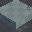

In [7]:
# The following steps through an entire episode from start to finish with random actions (by default)

end, reward, state = environment.reset()

while (end == 0):
    action = agent.step(end, reward, state)
    end, reward, state = environment.step(action)

# Let's run it a few more steps so that the things have time to settle down

for i in range(100):
    action = agent.step(end, reward, state)
    end, reward, state = environment.step(action)

environment.state2image(state)

In [58]:
class autoencoder(gluon.Block):
    def __init__(self):
        super(autoencoder, self).__init__()
        with self.name_scope():
            self.encoder = gluon.nn.Sequential('encoder_')
            with self.encoder.name_scope():
#                 self.encoder.add(gluon.nn.Flatten())
                self.encoder.add(gluon.nn.Dense(512, activation='relu'))
                self.encoder.add(gluon.nn.Dense(256, activation='relu'))
                self.encoder.add(gluon.nn.Dense(128, activation='relu'))
                self.encoder.add(gluon.nn.Dense(64, activation='relu'))
                self.encoder.add(gluon.nn.Dense(12))

            self.decoder = gluon.nn.Sequential('decoder_')
            with self.decoder.name_scope():
                self.decoder.add(gluon.nn.Dense(64, activation='relu'))
                self.decoder.add(gluon.nn.Dense(128, activation='relu'))
                self.decoder.add(gluon.nn.Dense(256, activation='relu'))
                self.decoder.add(gluon.nn.Dense(512, activation='relu'))
                self.decoder.add(gluon.nn.Dense(size * 3, activation='tanh'))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [62]:
ctx = mx.cpu()

model = autoencoder()
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
criterion = gluon.loss.L2Loss()
optimizer = gluon.Trainer(model.collect_params(), 'adam',
                          {'learning_rate': 0.001,
                           'wd': 1e-5})

num_epochs = 100

for epoch in range(num_epochs):
    running_loss = 0.0
    n_total = 0.0
    
    end, reward, state = environment.reset()
    
    step = 0
    while (end == 0):
        step+=1
        action = agent.step(end, reward, state)
        end, reward, state = environment.step(action)

        image = np.array(state, "uint8").reshape(size, size, 3)

    
        with mx.autograd.record():
            mx_image = mx.ndarray.array(image.copy()).reshape(size, size*3)/255.0 - 0.5
            output = model(mx_image)
            output = output.reshape_like(mx_image)
            loss = criterion(output, mx_image)
        loss.backward()
        optimizer.step(image.shape[0])
        running_loss += mx.nd.sum(loss).asscalar()
        n_total += image.shape[0]
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, running_loss / n_total))

model.save_parameters('./simple_autoencoder.params')

epoch [1/100], loss:0.0068
epoch [2/100], loss:0.0035
epoch [3/100], loss:0.0029
epoch [4/100], loss:0.0024
epoch [5/100], loss:0.0023
epoch [6/100], loss:0.0022
epoch [7/100], loss:0.0021
epoch [8/100], loss:0.0021
epoch [9/100], loss:0.0019
epoch [10/100], loss:0.0017
epoch [11/100], loss:0.0015
epoch [12/100], loss:0.0015
epoch [13/100], loss:0.0015
epoch [14/100], loss:0.0014
epoch [15/100], loss:0.0014
epoch [16/100], loss:0.0014
epoch [17/100], loss:0.0013
epoch [18/100], loss:0.0014
epoch [19/100], loss:0.0013
epoch [20/100], loss:0.0012
epoch [21/100], loss:0.0012
epoch [22/100], loss:0.0012
epoch [23/100], loss:0.0012
epoch [24/100], loss:0.0012
epoch [25/100], loss:0.0012
epoch [26/100], loss:0.0012
epoch [27/100], loss:0.0012
epoch [28/100], loss:0.0012
epoch [29/100], loss:0.0011
epoch [30/100], loss:0.0011
epoch [31/100], loss:0.0011
epoch [32/100], loss:0.0011
epoch [33/100], loss:0.0011
epoch [34/100], loss:0.0011
epoch [35/100], loss:0.0011
epoch [36/100], loss:0.0012
e

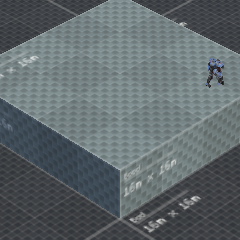

In [65]:
Image.fromarray(np.array(image,'uint8'))

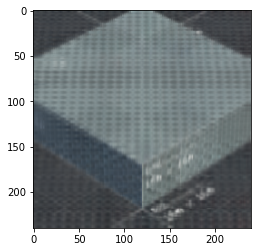

In [66]:
# Autoencoder reconstruction
plt.imshow(np.clip(output.asnumpy().reshape(size, size, 3) + 0.5, 0, 1))

In [127]:
model.load_parameters('./simple_autoencoder.params')

In [21]:
    def get_color_coords(image):
        boundaries = [
        ([17, 15, 130], [80, 100, 200]), #Blue
        ([86, 31, 4], [220, 88, 50]), #Red
        ]
        coords = []
        for (lower, upper) in boundaries:
            # create NumPy arrays from the boundaries
            lower = np.array(lower, dtype = 'uint8')
            upper = np.array(upper, dtype = 'uint8')
            # find the colors within the specified boundaries and apply
            # the mask
            mask = cv2.inRange(image, lower, upper)
            output = cv2.bitwise_and(image, image, mask = mask)
            coords.append(np.mean(np.array(list(set(zip(np.nonzero(output)[0],np.nonzero(output)[1])))), axis = 0))
        for idx in range(len(coords)):
            if np.isnan(coords[idx]).all():
                coords[idx] = np.array([0,0])
        return np.array(coords)-size/2

In [27]:
def eval_genomes(genomes, config):
    end, reward, state = environment.reset()

    for genome_id, genome in genomes:
        genome.fitness = 0.0
        
        net = neat.nn.FeedForwardNetwork.create(genome, config)

    while (end == 0):
        genome.fitness -= 0.02
        image = np.array(state, "uint8").reshape(size, size, 3)
        output = net.activate(get_color_coords(image).flatten())

        action = np.argmax(output)
#         action = agent.step(end, reward, state, action)
        end, reward, state = environment.step(action)
        genome.fitness += reward

def run(config_file):

    
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
#     p.add_reporter(neat.Checkpointer(5))

    # Run for up to 300 generations.
    winner = p.run(eval_genomes, 300)

    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))

    # Show output of the most fit genome against training data.
#     print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
#     for xi, xo in zip(xor_inputs, xor_outputs):
#         output = winner_net.activate(xi)
#         print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

#     p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
#     p.run(eval_genomes, 10)
    

if __name__ == '__main__':
    # Determine path to configuration file. This path manipulation is
    # here so that the script will run successfully regardless of the
    # current working directory.
#     local_dir = os.path.dirname(r"C:\Users\Tijs\Documents\Universiteit Tijs\First Year MSc\NIPS\.")
    config_path = 'config-feedforward.txt'
    run(config_path)


 ****** Running generation 0 ****** 

Population's average fitness: 0.16360 stdev: 1.14520
Best fitness: 8.18000 - size: (3, 12) - species 1 - id 50
Average adjusted fitness: 0.020
Mean genetic distance 0.986, standard deviation 0.275
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    50      8.2    0.020     0
Total extinctions: 0
Generation time: 4.013 sec

 ****** Running generation 1 ****** 

Population's average fitness: -0.00760 stdev: 0.05320
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 50
Average adjusted fitness: 0.372
Mean genetic distance 1.031, standard deviation 0.271
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    50      0.0    0.372     1
Total extinctions: 0
Generation time: 0.866 sec (2.440 average)

 ****** Running generation 2 ****** 

Population's average fitness: -0.00760 stdev: 

Population's average fitness: 0.15760 stdev: 1.10320
Best fitness: 7.88000 - size: (6, 10) - species 1 - id 914
Average adjusted fitness: 0.020
Mean genetic distance 1.729, standard deviation 0.448
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   18    50      7.9    0.020    18
Total extinctions: 0
Generation time: 4.631 sec (5.727 average)

 ****** Running generation 19 ****** 

Population's average fitness: -0.00760 stdev: 0.05320
Best fitness: 0.00000 - size: (6, 10) - species 1 - id 914
Average adjusted fitness: 0.372
Mean genetic distance 1.588, standard deviation 0.515
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   19    50      0.0    0.372    19
Total extinctions: 0
Generation time: 0.984 sec (5.730 average)

 ****** Running generation 20 ****** 

Population's average fitness: 0.11040 stdev: 0.77280
Best fitness

Population's average fitness: 0.18280 stdev: 1.27960
Best fitness: 9.14000 - size: (5, 8) - species 1 - id 1778
Average adjusted fitness: 0.020
Mean genetic distance 1.647, standard deviation 0.516
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   36    50      9.1    0.020     0
Total extinctions: 0
Generation time: 1.948 sec (5.476 average)

 ****** Running generation 37 ****** 

Population's average fitness: 0.09320 stdev: 0.65240
Best fitness: 4.66000 - size: (3, 10) - species 1 - id 1826
Average adjusted fitness: 0.020
Mean genetic distance 1.698, standard deviation 0.523
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   37    50      4.7    0.020     1
Total extinctions: 0
Generation time: 11.640 sec (6.175 average)

 ****** Running generation 38 ****** 

Population's average fitness: 0.16760 stdev: 1.17320
Best fitnes

Population's average fitness: -0.08800 stdev: 0.61600
Best fitness: 0.00000 - size: (4, 7) - species 1 - id 2594
Average adjusted fitness: 0.980
Mean genetic distance 1.394, standard deviation 0.382
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   54    50      0.0    0.980    18
Total extinctions: 0
Generation time: 9.510 sec (2.450 average)

 ****** Running generation 55 ****** 

Population's average fitness: -0.00720 stdev: 0.05040
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.353
Mean genetic distance 1.408, standard deviation 0.468
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   55    50      0.0    0.353    19
Total extinctions: 0
Generation time: 0.880 sec (2.428 average)

 ****** Running generation 56 ****** 

Population's average fitness: -0.00720 stdev: 0.05040
Best fitness

Population's average fitness: 0.11280 stdev: 0.78960
Best fitness: 5.64000 - size: (8, 14) - species 1 - id 3506
Average adjusted fitness: 0.020
Mean genetic distance 1.348, standard deviation 0.426
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   72    50      5.6    0.020    36
Total extinctions: 0
Generation time: 9.461 sec (3.367 average)

 ****** Running generation 73 ****** 

Population's average fitness: -0.00720 stdev: 0.05040
Best fitness: 0.00000 - size: (8, 14) - species 1 - id 3506
Average adjusted fitness: 0.353
Mean genetic distance 1.529, standard deviation 0.438
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   73    50      0.0    0.353    37
Total extinctions: 0
Generation time: 0.981 sec (3.360 average)

 ****** Running generation 74 ****** 

Population's average fitness: -0.00800 stdev: 0.05600
Best fitn

Population's average fitness: -0.00720 stdev: 0.05040
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.353
Mean genetic distance 1.207, standard deviation 0.321
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   90    50      0.0    0.353    54
Total extinctions: 0
Generation time: 0.919 sec (1.346 average)

 ****** Running generation 91 ****** 

Population's average fitness: -0.01080 stdev: 0.07560
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.529
Mean genetic distance 1.307, standard deviation 0.380
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   91    50      0.0    0.529    55
Total extinctions: 0
Generation time: 1.330 sec (1.389 average)

 ****** Running generation 92 ****** 

Population's average fitness: -0.00840 stdev: 0.05880
Best fitness: 

Population's average fitness: -0.00720 stdev: 0.05040
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.353
Mean genetic distance 1.318, standard deviation 0.437
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  108    50      0.0    0.353    72
Total extinctions: 0
Generation time: 0.948 sec (1.470 average)

 ****** Running generation 109 ****** 

Population's average fitness: -0.00680 stdev: 0.04760
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.333
Mean genetic distance 1.327, standard deviation 0.406
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  109    50      0.0    0.333    73
Total extinctions: 0
Generation time: 0.933 sec (1.462 average)

 ****** Running generation 110 ****** 

Population's average fitness: 0.12000 stdev: 0.84000
Best fitness:

Population's average fitness: -0.00560 stdev: 0.03920
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.274
Mean genetic distance 1.237, standard deviation 0.429
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  126    50      0.0    0.274     7
Total extinctions: 0
Generation time: 0.749 sec (2.343 average)

 ****** Running generation 127 ****** 

Population's average fitness: -0.00800 stdev: 0.05600
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.392
Mean genetic distance 1.377, standard deviation 0.331
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  127    50      0.0    0.392     8
Total extinctions: 0
Generation time: 0.997 sec (2.350 average)

 ****** Running generation 128 ****** 

Population's average fitness: -0.00680 stdev: 0.04760
Best fitness

Population's average fitness: 0.17160 stdev: 1.20120
Best fitness: 8.58000 - size: (3, 4) - species 1 - id 6962
Average adjusted fitness: 0.020
Mean genetic distance 1.439, standard deviation 0.443
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  144    50      8.6    0.020    25
Total extinctions: 0
Generation time: 3.298 sec (2.364 average)

 ****** Running generation 145 ****** 

Population's average fitness: 0.10400 stdev: 0.72800
Best fitness: 5.20000 - size: (3, 4) - species 1 - id 7010
Average adjusted fitness: 0.020
Mean genetic distance 1.425, standard deviation 0.316
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  145    50      5.2    0.020    26
Total extinctions: 0
Generation time: 11.125 sec (3.319 average)

 ****** Running generation 146 ****** 

Population's average fitness: -0.00720 stdev: 0.05040
Best fitn

Population's average fitness: 0.18480 stdev: 1.29360
Best fitness: 9.24000 - size: (3, 9) - species 1 - id 7826
Average adjusted fitness: 0.020
Mean genetic distance 1.143, standard deviation 0.369
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  162    50      9.2    0.020    43
Total extinctions: 0
Generation time: 1.749 sec (3.405 average)

 ****** Running generation 163 ****** 

Population's average fitness: -0.00680 stdev: 0.04760
Best fitness: 0.00000 - size: (3, 9) - species 1 - id 7826
Average adjusted fitness: 0.333
Mean genetic distance 1.136, standard deviation 0.393
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  163    50      0.0    0.333    44
Total extinctions: 0
Generation time: 0.884 sec (3.405 average)

 ****** Running generation 164 ****** 

Population's average fitness: -0.00720 stdev: 0.05040
Best fitn

Population's average fitness: -0.00720 stdev: 0.05040
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.353
Mean genetic distance 1.170, standard deviation 0.347
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  180    50      0.0    0.353    61
Total extinctions: 0
Generation time: 0.915 sec (4.989 average)

 ****** Running generation 181 ****** 

Population's average fitness: -0.00760 stdev: 0.05320
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.372
Mean genetic distance 1.210, standard deviation 0.448
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  181    50      0.0    0.372    62
Total extinctions: 0
Generation time: 0.948 sec (4.992 average)

 ****** Running generation 182 ****** 

Population's average fitness: 0.18400 stdev: 1.28800
Best fitness:

Population's average fitness: -0.03400 stdev: 0.23800
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.980
Mean genetic distance 1.331, standard deviation 0.528
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  198    50      0.0    0.980     9
Total extinctions: 0
Generation time: 4.010 sec (3.915 average)

 ****** Running generation 199 ****** 

Population's average fitness: -0.00720 stdev: 0.05040
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.353
Mean genetic distance 1.400, standard deviation 0.527
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  199    50      0.0    0.353    10
Total extinctions: 0
Generation time: 0.915 sec (3.922 average)

 ****** Running generation 200 ****** 

Population's average fitness: 0.18240 stdev: 1.27680
Best fitness:

Population's average fitness: -0.00840 stdev: 0.05880
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.412
Mean genetic distance 1.407, standard deviation 0.569
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  216    50      0.0    0.412    27
Total extinctions: 0
Generation time: 1.116 sec (1.409 average)

 ****** Running generation 217 ****** 

Population's average fitness: -0.00840 stdev: 0.05880
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.412
Mean genetic distance 1.349, standard deviation 0.528
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  217    50      0.0    0.412    28
Total extinctions: 0
Generation time: 1.151 sec (1.051 average)

 ****** Running generation 218 ****** 

Population's average fitness: -0.00600 stdev: 0.04200
Best fitness

Population's average fitness: 0.18040 stdev: 1.26280
Best fitness: 9.02000 - size: (3, 12) - species 1 - id 11282
Average adjusted fitness: 0.020
Mean genetic distance 1.168, standard deviation 0.406
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  234    50      9.0    0.020    45
Total extinctions: 0
Generation time: 2.329 sec (1.074 average)

 ****** Running generation 235 ****** 

Population's average fitness: -0.00720 stdev: 0.05040
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 11282
Average adjusted fitness: 0.353
Mean genetic distance 1.240, standard deviation 0.399
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  235    50      0.0    0.353    46
Total extinctions: 0
Generation time: 0.916 sec (1.090 average)

 ****** Running generation 236 ****** 

Population's average fitness: -0.04640 stdev: 0.32480
Best 

Population's average fitness: -0.00720 stdev: 0.05040
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.353
Mean genetic distance 1.105, standard deviation 0.467
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  252    50      0.0    0.353    63
Total extinctions: 0
Generation time: 0.952 sec (3.634 average)

 ****** Running generation 253 ****** 

Population's average fitness: -0.00840 stdev: 0.05880
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.412
Mean genetic distance 0.989, standard deviation 0.368
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  253    50      0.0    0.412    64
Total extinctions: 0
Generation time: 1.080 sec (3.137 average)

 ****** Running generation 254 ****** 

Population's average fitness: -0.00640 stdev: 0.04480
Best fitness

Population's average fitness: -0.00560 stdev: 0.03920
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.274
Mean genetic distance 1.211, standard deviation 0.386
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  270    50      0.0    0.274    81
Total extinctions: 0
Generation time: 0.799 sec (2.693 average)

 ****** Running generation 271 ****** 

Population's average fitness: -0.00680 stdev: 0.04760
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.333
Mean genetic distance 1.230, standard deviation 0.321
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  271    50      0.0    0.333    82
Total extinctions: 0
Generation time: 0.970 sec (2.695 average)

 ****** Running generation 272 ****** 

Population's average fitness: -0.00800 stdev: 0.05600
Best fitness

Population's average fitness: -0.00720 stdev: 0.05040
Best fitness: 0.00000 - size: (4, 5) - species 1 - id 13826
Average adjusted fitness: 0.353
Mean genetic distance 1.334, standard deviation 0.399
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  288    50      0.0    0.353    99
Total extinctions: 0
Generation time: 0.964 sec (4.106 average)

 ****** Running generation 289 ****** 

Population's average fitness: -0.00720 stdev: 0.05040
Best fitness: 0.00000 - size: (3, 12) - species 1 - id 1
Average adjusted fitness: 0.353
Mean genetic distance 1.370, standard deviation 0.391
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  289    50      0.0    0.353   100
Total extinctions: 0
Generation time: 0.966 sec (4.116 average)

 ****** Running generation 290 ****** 

Population's average fitness: 0.18720 stdev: 1.31040
Best fitne